#  Modified Triplet Loss : Ungraded Lecture Notebook
In this notebook you'll see how to calculate the full triplet loss, step by step, including the mean negative and the closest negative. You'll also calculate the matrix of similarity scores.

## Background
This is the original triplet loss function:

$\mathcal{L_\mathrm{Original}} = \max{(\mathrm{s}(A,N) -\mathrm{s}(A,P) +\alpha, 0)}$

It can be improved by including the mean negative and the closest negative, to create a new full loss function. The inputs are the Anchor $\mathrm{A}$, Positive $\mathrm{P}$ and Negative $\mathrm{N}$.

$\mathcal{L_\mathrm{1}} = \max{(mean\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

$\mathcal{L_\mathrm{2}} = \max{(closest\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

$\mathcal{L_\mathrm{Full}} = \mathcal{L_\mathrm{1}} + \mathcal{L_\mathrm{2}}$

Let me show you what that means exactly, and how to calculate each step.

## Imports

In [1]:
import numpy as np

## Similarity Scores
The first step is to calculate the matrix of similarity scores using cosine similarity so that you can look up $\mathrm{s}(A,P)$, $\mathrm{s}(A,N)$ as needed for the loss formulas.

### Two Vectors
First I'll show you how to calculate the similarity score, using cosine similarity, for 2 vectors.

$\mathrm{s}(v_1,v_2) = \mathrm{cosine \ similarity}(v_1,v_2) = \frac{v_1 \cdot v_2}{||v_1||~||v_2||}$
* Try changing the values in the second vector to see how it changes the cosine similarity.




In [2]:
# Two vector example
# Input data
print("-- Inputs --")
v1 = np.array([1, 2, 3], dtype=float)
v2 = np.array([1, 2, 3.5])  # notice the 3rd element is offset by 0.5
### START CODE HERE ###
# Try modifying the vector v2 to see how it impacts the cosine similarity
# v2 = v1                   # identical vector
# v2 = v1 * -1              # opposite vector
# v2 = np.array([0,-42,1])  # random example
### END CODE HERE ###
print("v1 :", v1)
print("v2 :", v2, "\n")

# Similarity score
def cosine_similarity(v1, v2):
    numerator = np.dot(v1, v2)
    denominator = np.sqrt(np.dot(v1, v1)) * np.sqrt(np.dot(v2, v2))
    return numerator / denominator

print("-- Outputs --")
print("cosine similarity :", cosine_similarity(v1, v2))

-- Inputs --
v1 : [1. 2. 3.]
v2 : [1.  2.  3.5] 

-- Outputs --
cosine similarity : 0.9974086507360697


### Two Batches of Vectors
Now i'll show you how to calculate the similarity scores, using cosine similarity, for 2 batches of vectors. These are rows of individual vectors, just like in the example above, but stacked vertically into a matrix. They would look like the image below for a batch size (row count) of 4 and embedding size (column count) of 5.

The data is setup so that $v_{1\_1}$ and $v_{2\_1}$ represent duplicate inputs, but they are not duplicates with any other rows in the batch. This means $v_{1\_1}$ and $v_{2\_1}$ (green and green) have more similar vectors than say $v_{1\_1}$ and $v_{2\_2}$ (green and magenta).

I'll show you two different methods for calculating the matrix of similarities from 2 batches of vectors.

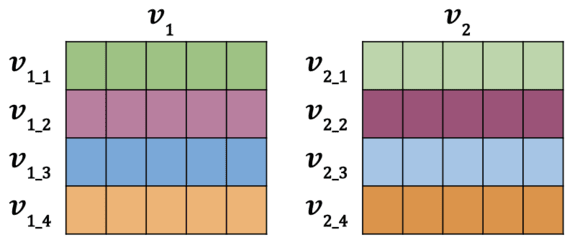

In [3]:
# Two batches of vectors example
# Input data
print("-- Inputs --")
v1_1 = np.array([1, 2, 3])
v1_2 = np.array([9, 8, 7])
v1_3 = np.array([-1, -4, -2])
v1_4 = np.array([1, -7, 2])
v1 = np.vstack([v1_1, v1_2, v1_3, v1_4])
print("v1 :")
print(v1, "\n")
v2_1 = v1_1 + np.random.normal(0, 2, 3)  # add some noise to create approximate duplicate
v2_2 = v1_2 + np.random.normal(0, 2, 3)
v2_3 = v1_3 + np.random.normal(0, 2, 3)
v2_4 = v1_4 + np.random.normal(0, 2, 3)
v2 = np.vstack([v2_1, v2_2, v2_3, v2_4])
print("v2 :")
print(v2, "\n")

# Batch sizes must match
b = len(v1)
print("batch sizes match :", b == len(v2), "\n")

# Similarity scores
print("-- Outputs --")
# Option 1 : nested loops and the cosine similarity function
sim_1 = np.zeros([b, b])  # empty array to take similarity scores
# Loop
for row in range(0, sim_1.shape[0]):
    for col in range(0, sim_1.shape[1]):
        sim_1[row, col] = cosine_similarity(v1[row], v2[col])

print("option 1 : loop")
print(sim_1, "\n")

# Option 2 : vector normalization and dot product
def norm(x):
    return x / np.sqrt(np.sum(x * x, axis=1, keepdims=True))

sim_2 = np.dot(norm(v1), norm(v2).T)

print("option 2 : vec norm & dot product")
print(sim_2, "\n")

# Check
print("outputs are the same :", np.allclose(sim_1, sim_2))

-- Inputs --
v1 :
[[ 1  2  3]
 [ 9  8  7]
 [-1 -4 -2]
 [ 1 -7  2]] 

v2 :
[[ 0.64277611  5.04376577  4.47268105]
 [ 8.36668242  7.1970528   5.68722752]
 [-1.61306441 -3.63247645 -0.93712139]
 [-1.60850124 -6.72547786  1.12161828]] 

batch sizes match : True 

-- Outputs --
option 1 : loop
[[ 0.95305453  0.85723831 -0.76505707 -0.44614995]
 [ 0.82107064  0.99861151 -0.88150724 -0.61930417]
 [-0.95910087 -0.85296695  0.96281818  0.81820694]
 [-0.51681886 -0.33581819  0.73115022  0.92682981]] 

option 2 : vec norm & dot product
[[ 0.95305453  0.85723831 -0.76505707 -0.44614995]
 [ 0.82107064  0.99861151 -0.88150724 -0.61930417]
 [-0.95910087 -0.85296695  0.96281818  0.81820694]
 [-0.51681886 -0.33581819  0.73115022  0.92682981]] 

outputs are the same : True


## Hard Negative Mining

I'll now show you how to calculate the mean negative $mean\_neg$ and the closest negative $close\_neg$ used in calculating $\mathcal{L_\mathrm{1}}$ and $\mathcal{L_\mathrm{2}}$.


$\mathcal{L_\mathrm{1}} = \max{(mean\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

$\mathcal{L_\mathrm{2}} = \max{(closest\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

You'll do this using the matrix of similarity scores you already know how to make, like the example below for a batch size of 4. The diagonal of the matrix contains all the $\mathrm{s}(A,P)$ values, similarities from duplicate question pairs (aka Positives). This is an important attribute for the calculations to follow.

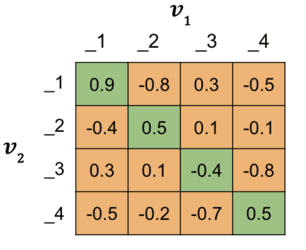


### Mean Negative
$mean\_neg$ is the average of the off diagonals, the $\mathrm{s}(A,N)$ values, for each row.

### Closest Negative
$closest\_neg$ is the largest off diagonal value, $\mathrm{s}(A,N)$, that is smaller than the diagonal $\mathrm{s}(A,P)$ for each row.
* Try using a different matrix of similarity scores. 

In [4]:
# Hardcoded matrix of similarity scores
sim_hardcoded = np.array(
    [
        [0.9, -0.8, 0.3, -0.5],
        [-0.4, 0.5, 0.1, -0.1],
        [0.3, 0.1, -0.4, -0.8],
        [-0.5, -0.2, -0.7, 0.5],
    ]
)

sim = sim_hardcoded
### START CODE HERE ###
# Try using different values for the matrix of similarity scores
# sim = 2 * np.random.random_sample((b,b)) -1   # random similarity scores between -1 and 1
# sim = sim_2                                   # the matrix calculated previously using vector normalization and dot product
### END CODE HERE ###

# Batch size
b = sim.shape[0]

print("-- Inputs --")
print("sim :")
print(sim)
print("shape :", sim.shape, "\n")

# Positives
# All the s(A,P) values : similarities from duplicate question pairs (aka Positives)
# These are along the diagonal
sim_ap = np.diag(sim)
print("sim_ap :")
print(np.diag(sim_ap), "\n")

# Negatives
# all the s(A,N) values : similarities the non duplicate question pairs (aka Negatives)
# These are in the off diagonals
sim_an = sim - np.diag(sim_ap)
print("sim_an :")
print(sim_an, "\n")

print("-- Outputs --")
# Mean negative
# Average of the s(A,N) values for each row
mean_neg = np.sum(sim_an, axis=1, keepdims=True) / (b - 1)
print("mean_neg :")
print(mean_neg, "\n")

# Closest negative
# Max s(A,N) that is <= s(A,P) for each row
mask_1 = np.identity(b) == 1            # mask to exclude the diagonal
mask_2 = sim_an > sim_ap.reshape(b, 1)  # mask to exclude sim_an > sim_ap
mask = mask_1 | mask_2
sim_an_masked = np.copy(sim_an)         # create a copy to preserve sim_an
sim_an_masked[mask] = -2

closest_neg = np.max(sim_an_masked, axis=1, keepdims=True)
print("closest_neg :")
print(closest_neg, "\n")

-- Inputs --
sim :
[[ 0.9 -0.8  0.3 -0.5]
 [-0.4  0.5  0.1 -0.1]
 [ 0.3  0.1 -0.4 -0.8]
 [-0.5 -0.2 -0.7  0.5]]
shape : (4, 4) 

sim_ap :
[[ 0.9  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.4  0. ]
 [ 0.   0.   0.   0.5]] 

sim_an :
[[ 0.  -0.8  0.3 -0.5]
 [-0.4  0.   0.1 -0.1]
 [ 0.3  0.1  0.  -0.8]
 [-0.5 -0.2 -0.7  0. ]] 

-- Outputs --
mean_neg :
[[-0.33333333]
 [-0.13333333]
 [-0.13333333]
 [-0.46666667]] 

closest_neg :
[[ 0.3]
 [ 0.1]
 [-0.8]
 [-0.2]] 



## The Loss Functions

The last step is to calculate the loss functions.

$\mathcal{L_\mathrm{1}} = \max{(mean\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

$\mathcal{L_\mathrm{2}} = \max{(closest\_neg -\mathrm{s}(A,P)  +\alpha, 0)}$

$\mathcal{L_\mathrm{Full}} = \mathcal{L_\mathrm{1}} + \mathcal{L_\mathrm{2}}$

In [5]:
# Alpha margin
alpha = 0.25

# Modified triplet loss
# Loss 1
l_1 = np.maximum(mean_neg - sim_ap.reshape(b, 1) + alpha, 0)
# Loss 2
l_2 = np.maximum(closest_neg - sim_ap.reshape(b, 1) + alpha, 0)
# Loss full
l_full = l_1 + l_2
# Cost
cost = np.sum(l_full)

print("-- Outputs --")
print("loss full :")
print(l_full, "\n")
print("cost :", "{:.3f}".format(cost))

-- Outputs --
loss full :
[[0.        ]
 [0.        ]
 [0.51666667]
 [0.        ]] 

cost : 0.517


## Summary
There were a lot of steps in there, so well done. You now know how to calculate a modified triplet loss, incorporating the mean negative and the closest negative. You also learned how to create a matrix of similarity scores based on cosine similarity.